In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
import math
import time

In [3]:
import pyrootutils
import hydra

root = pyrootutils.setup_root(search_from="./", indicator=[".git", "pyproject.toml"], pythonpath=True, dotenv=True)


In [4]:
import matplotlib.pyplot as plt

In [5]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize("../configs/datamodule/", version_base="1.2")
data_module = hydra.compose("lung_lobe_segmentation_datamodule.yaml")

In [6]:
data_module

{'transforms': {'val_transforms': {'_target_': 'monai.transforms.Compose', 'transforms': [{'_target_': 'src.common.transforms.monai_extras.LoadDcmData', 'keys': ['image', 'lung_label', 'lobe_label']}, {'_target_': 'src.common.transforms.monai_extras.CTCrop', 'image_key': 'image', 'mask_keys': ['lung_label', 'lobe_label']}, {'_target_': 'src.common.transforms.monai_extras.Resize3D', 'image_key': 'image', 'label_keys': ['lung_label', 'lobe_label'], 'spatial_size': [160, 224, 224]}, {'_target_': 'src.common.transforms.monai_extras.ApplyWindowsChannelWise', 'keys': ['image'], 'windows': ['Custom LungD', 'Custom LungB', 'Custom LungA']}, {'_target_': 'src.common.transforms.monai_extras.ExpandDim', 'keys': ['image', 'lung_label', 'lobe_label']}]}, 'train_transforms': {'_target_': 'monai.transforms.Compose', 'transforms': [{'_target_': 'src.common.transforms.monai_extras.LoadDcmData', 'keys': ['image', 'lung_label', 'lobe_label']}, {'_target_': 'src.common.transforms.monai_extras.CTCrop', 'im

In [7]:
spatial_dims = 3

In [8]:
if spatial_dims == 2 :
    data_module["data_cfg"]["num_slices_per_volume"] = 1
    data_module["data_cfg"]["stride"] = 0
    data_module["dataloader_cfg"]["batch_size"] = 32

In [9]:
datamodule = hydra.utils.instantiate(data_module)
# train_dataloader = datamodule.train_dataloader()
# batch = next(iter(train_dataloader))
# batch.keys()

2023-05-01 17:36:25.855 | DEBUG    | src.datamodules.load_data.lung_lobe_segmentation:lung_segmentation_data_loader:163 - Loading train data from /home/users/shubham.kumar/projects/lung_lobe_segmentation/lung_lobe_cct_data.csv with frac 0 and size None.
2023-05-01 17:36:25.860 | DEBUG    | src.datamodules.load_data.lung_lobe_segmentation:lung_segmentation_data_loader:163 - Loading train data from /home/users/shubham.kumar/projects/lung_lobe_segmentation/LCTSC_dataset.csv with frac 0 and size None.
2023-05-01 17:36:25.862 | DEBUG    | src.datamodules.load_data.lung_lobe_segmentation:lung_segmentation_data_loader:163 - Loading train data from /home/users/shubham.kumar/projects/lung_lobe_segmentation/LOLA_dataset.csv with frac 0 and size None.
2023-05-01 17:36:25.865 | DEBUG    | src.datamodules.load_data.lung_lobe_segmentation:lung_segmentation_data_loader:163 - Loading train data from /home/users/shubham.kumar/projects/lung_lobe_segmentation/LIDC_dataset.csv with frac 1 and size None.
2

In [7]:
from torch.nn.functional import interpolate
import time

In [8]:
a = torch.randn((400,512,512))

In [9]:
b =time.time()
r = interpolate(a.unsqueeze(0).unsqueeze(0), scale_factor = (0.5,0.5,0.5))
print(time.time() - b)

0.024911165237426758


In [10]:
r.shape

torch.Size([1, 1, 200, 256, 256])

In [10]:
val_dataloader = datamodule.val_dataloader()
val_batch = next(iter(val_dataloader))


In [23]:
# train_dataloader = datamodule.train_dataloader()
train_batch = next(iter(train_dataloader))


In [24]:
lung_label = train_batch["lung_label"]
lobe_label = train_batch["lobe_label"]

In [11]:
lung_label.shape

torch.Size([4, 1, 32, 224, 224])

In [15]:
len(torch.unique(lung_label))

2

In [13]:
lung_label[lung_label > 0] = 1

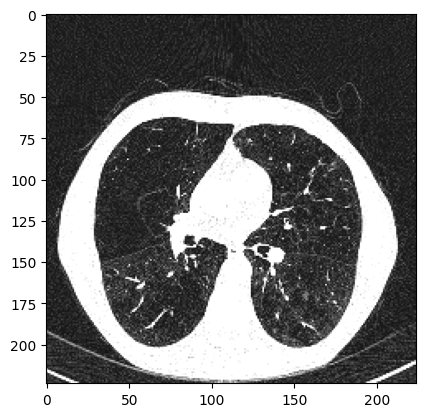

In [15]:
plt.imshow(train_batch['image'][3][0][10] ,cmap ="gray")
plt.show()

In [16]:
from torch.nn import ModuleDict

In [17]:
di = {"lung" : 545 , "lobe": 476} 

In [18]:
ModuleDict(di)

TypeError: int is not a Module subclass

In [ ]:
# batch = next(iter(train_dataloader))
# batch.keys()

In [10]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize("../configs/model/net/segmentation", version_base="1.2")

hydra.initialize()

In [11]:
timm_model_config = hydra.compose("timm_models.yaml")


In [12]:
timm_model_config

{'model': {'net': {'_target_': 'src.common.nn_modules.nets.segmentation.timm_models.TimmSegModel', 'in_channels': 3, 'num_classes': [6, 3], 'label_keys': ['lobe_label', 'lung_label'], 'n_blocks': 5, 'decoder_channels': [256, 128, 64, 32, 16], 'backbone': 'resnet34', 'segtype': 'unet++', 'drop_rate': 0.05, 'spatial_dims': 3}}}

In [141]:
timm_model_config['model']['net']['backbone'] = "resnet18"
timm_model_config['model']['net']['segtype'] = "unet"
timm_model_config['model']['net']['spatial_dims'] = spatial_dims

In [13]:
timm_model = hydra.utils.instantiate(timm_model_config)
timm_model_3D = timm_model['model']['net']

In [14]:
timm_model_3D

TimmSegModel(
  (encoder): FeatureListNet(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_s

In [29]:
for i, (name, layer) in enumerate(timm_model_3D.named_modules()):
    if isinstance(layer, torch.nn.ReLU):
        layer = torch.nn.ReLU(inplace=False)
        timm_model_3D.register_module(name,layer)

KeyError: 'module name can\'t contain ".", got: encoder.act1'

TimmSegModel(
  (encoder): FeatureListNet(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_s

In [144]:
batch['image'].squeeze(2).shape

torch.Size([4, 3, 32, 224, 224])

In [145]:
start_time = time.time()
a = timm_model_3D(batch['image'].squeeze(2))
end_time = time.time() - start_time
print(end_time)

3.4717776775360107


In [116]:
start_time = time.time()
a = timm_model_3D(batch['image'])
end_time = time.time() - start_time
print(end_time)

1.88377046585083


In [130]:
start_time = time.time()
a = timm_model_3D(batch['image'])
end_time = time.time() - start_time
print(end_time)

3.098605155944824


In [125]:
math.ceil(200/32)

7

In [95]:
a['lobe_label'].shape

torch.Size([4, 6, 16, 224, 224])

In [ ]:
timm_models.TimmSegModel()

In [46]:
batch['image'][:,:,0,:,:].shape

torch.Size([4, 3, 224, 224])

In [47]:
batch['image'].shape

torch.Size([4, 3, 16, 224, 224])

In [6]:
a = torch.zeros((32,512,512))

In [7]:
batch["image"].shape

torch.Size([32, 512, 512])

In [12]:
input = torch.randn(4)


In [4]:
from torch import Tensor
from torchmetrics import Metric , Accuracy, Precision, Recall, AUROC, ConfusionMatrix, AveragePrecision, Bi
from torchmetrics import MetricCollection

In [ ]:
from torchmetrics.classification import B

In [27]:
metrics_to_evaluate = torch.nn.ModuleDict({'accuracy': Accuracy(), 'sensitivity': Recall(), 'average_precision': AveragePrecision(), 'auc': AUC()})



In [14]:
pred = torch.tensor([[0.4928, 0.5072],
        [0.4914, 0.5086],
        [0.4928, 0.5072],
        [0.4919, 0.5081]])

In [17]:
# pred = torch.tensor([0, 0.1, 0.4, 0.8])
target = torch.tensor([0, 1, 1, 1])
average_precision = Accuracy(task = "multiclass" , num_classes =2)
average_precision(pred, target)

tensor(0.7500)

In [13]:
torch.randn()

tensor([ 1.2973, -1.0304, -1.3033, -1.0999])

In [18]:
import numpy as np

In [20]:
torch.tensor(np.array(1))

tensor([6.3475e-34])

In [8]:
batch.keys()


NameError: name 'batch' is not defined

In [50]:
image, lung_label , lobe_label = batch["image"], batch["lung_label"] , batch["lobe_label"]


In [5]:
batch.keys

NameError: name 'batch' is not defined

In [52]:
lung_label.shape

torch.Size([8, 1, 16, 224, 224])

In [53]:
lobe_label.shape


torch.Size([8, 1, 16, 224, 224])

In [21]:
right = [1,2]  --> 2
left = [3,4,5]  --> 1

class CombineLobeOutputintoLung(Transform) :
    def __init__(self) -> None:
        return 

    def __call__(self, data: Dict):
        # right = [1,2]
        # left = [3,4,5]

        lobe_label_copy = data["lobe_label"].clone()
        lobe_label_copy[lobe_label_copy == 1] = 20
        lobe_label_copy[lobe_label_copy == 2] = 20
        lobe_label_copy[lobe_label_copy == 3] = 10
        lobe_label_copy[lobe_label_copy == 4] = 10
        lobe_label_copy[lobe_label_copy == 5] = 10

        lobe_label_copy = lobe_label_copy/10
        lung_label = lobe_label_copy

        data["lobe_label"] = lung_label

        return data

In [37]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
from training_framework.common.nn_modules.nets.utils.convert_3d import convert_3d

In [20]:
import segmentation_models_pytorch as smp
import timm
import torch
import torch.nn as nn
from typing import List, Union
from segmentation_models_pytorch.unet.decoder import UnetDecoder

class TimmSegModel(nn.Module):
    def __init__(
        self,
        num_classes: Union[List[int], int] ,
        n_blocks: int,
        backbone: str,
        in_channels: int , 
        segtype="unet",
        pretrained=False,
        drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        attention_type = "scse"
    ):
        super().__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans= in_channels,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained,
        )
        self.n_blocks = n_blocks
        self.num_classes = num_classes
        g = self.encoder(torch.rand(1, in_channels, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [128, 64, 32, 16]
        if segtype == "unet":
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[: n_blocks + 1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )
        elif segtype == "unet++":
            self.decoder = smp.decoders.unetplusplus.decoder.UnetPlusPlusDecoder(
                encoder_channels=encoder_channels[: n_blocks + 1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
                use_batchnorm=True,
                attention_type= attention_type,
            )
            
        if isinstance(num_classes, int):
            self.segmentation_head = nn.Conv2d(
                decoder_channels[n_blocks - 1],
                num_classes,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
            )
        else:
            self.segmentation_head = nn.ModuleList(
                [
                    nn.Conv2d(
                        decoder_channels[n_blocks - 1],
                        num_classes[i],
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    )
                    for i in range(len(num_classes))
                ]
            )
   
        # convert to 3d
        self.encoder = convert_3d(self.encoder)
        self.decoder = convert_3d(self.decoder)
        self.segmentation_head = convert_3d(self.segmentation_head)

    def forward(self, x):
        global_features = [0] + self.encoder(x)[: self.n_blocks]
        for i in range(len(global_features)) :
            if i > 0 :
                print(global_features[i].shape)
            
        seg_features = self.decoder(*global_features)
        
        output = self.segmentation_head(seg_features)
        return output

In [21]:
model = TimmSegModel(num_classes = [6, 3], in_channels = 3, n_blocks = 4 , backbone= "resnet18")

In [22]:
model = model.to("cuda:1")

In [59]:
image.shape

torch.Size([8, 3, 16, 224, 224])

In [16]:
img = torch.randn(2, 3, 16, 64, 64)

In [17]:
img = img.to("cuda:1")

In [19]:
model

TimmSegModel(
  (encoder): FeatureListNet(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_s

In [23]:
a = model(img)

torch.Size([2, 64, 8, 32, 32])
torch.Size([2, 64, 4, 16, 16])
torch.Size([2, 128, 2, 8, 8])
torch.Size([2, 256, 1, 4, 4])


NotImplementedError: 

In [27]:
from training_framework.common.nn_modules.nets.segmentation import unet_3p

In [33]:
model = unet_3p.Unet3p(
        spatial_dims=3,
        in_channels=2,
        out_channels=3,
    )
# model.eval()
# model.cuda()
batch_size = 2
x = torch.rand((batch_size, 2, 16, 64, 64))
# with torch.no_grad():
seg_logits = model(
    x
)  # B X out_channels X D X H X W , [B X class_head_num_cls[i] for i in range(len(class_head_num_cls))]
print(seg_logits.shape)


BasicUNet features: (64, 128, 256, 512, 1024).
torch.Size([2, 3, 16, 64, 64])


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import qure_segmentation_models_pytorch as qure_smp
from typing import List

from qure_segmentation_models_pytorch.encoders import get_encoder
from qure_segmentation_models_pytorch.base import SegmentationHead_3D
from qure_segmentation_models_pytorch.decoders.unet_3D import UnetDecoder_3D
from segmentation_models_pytorch.base import initialization as init


class TimmSegModel(nn.Module):
    def __init__(
        self,
        num_classes: List[int],
        in_channels : int,
        n_blocks: int,
        backbone: str,
        decoder_channels: List[int],
        use_batchnorm: bool = True,
        attention_type = "scse",

    ):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.num_classes = num_classes

        self.encoder = get_encoder(
            backbone,
            in_channels=in_channels,
            depth= n_blocks,
            weights=None,
        )

        self.decoder = UnetDecoder_3D(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels[: self.n_blocks],
            n_blocks= n_blocks,
            use_batchnorm= use_batchnorm,
            center=True if backbone.startswith("vgg") else False,
            attention_type= attention_type,
        )
        self.segmentation_head_6 = SegmentationHead_3D(
                    in_channels=decoder_channels[-1],
                    out_channels=num_classes[0],
                    activation= "None",
                    kernel_size=3,
                    temporal_size=1
                )
        
        self.segmentation_head_3 = SegmentationHead_3D(
                    in_channels=decoder_channels[-1],
                    out_channels=num_classes[1],
                    activation= "None",
                    kernel_size=3,
                    temporal_size=1
                )

        
#         self.initialize()
            
#     def initialize(self):
#         init.initialize_decoder(self.decoder)
#         for num_class in self.num_classes:
#             init.initialize_head(self.__getattribute__(f"segmentation_head_{num_class}"))

    def forward(self, x):
        global_features = self.encoder(x)
        seg_features = self.decoder(*global_features)

        output = []
        output.append(self.segmentation_head_6(seg_features))
        output.append(self.segmentation_head_3(seg_features))

#         torch.stack(output, dim=1)

        return output


In [28]:
model = TimmSegModel(num_classes = [6, 3] ,n_blocks = 3 , backbone= "resnet18_3D", 
                     decoder_channels = [64,32,16] , in_channels= 3 , attention_type = "scse_3D")


In [100]:
model

TimmSegModel(
  (encoder): ResNetEncoder_3D(
    (conv1): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock_3D(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock_3D(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=Fals

In [15]:
from monai.transforms import DivisiblePadd, RandomizableTransform, Resize, Transform


In [16]:
resize = Resize((224,224))

In [14]:
image[0][0].shape

torch.Size([16, 224, 224])

In [22]:
resize(image[0][0]).shape

torch.Size([16, 224, 224])

In [29]:
model = model.to("cuda:1")

In [14]:
image = image.to("cuda:1")

In [38]:
image = image.detach()

In [47]:
out = model(image)

In [39]:
!nvidia-smi


Mon Apr 10 22:41:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    Off  | 00000000:21:00.0 Off |                  N/A |
| 40%   31C    P8    13W / 280W |  12885MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN RTX    Off  | 00000000:4A:00.0 Off |                  N/A |
| 41%   

In [31]:
len(out)

2

In [48]:
out[0].shape

torch.Size([8, 6, 16, 224, 224])

In [56]:
r = out[0][0][:,1]

In [64]:
t = act(r)

In [66]:
r[1]

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:1',
       grad_fn=<SelectBackward0>)

In [33]:
out[1].shape

torch.Size([8, 3, 16, 224, 224])

In [34]:
out[1][0].shape

torch.Size([3, 16, 224, 224])

In [76]:
act = torch.nn.Softmax(dim =)

In [45]:
act(out[1])

torch.Size([8, 3, 16, 224, 224])

In [46]:
torch.softmax(out[1] , dim = 1).clone().shape

torch.Size([8, 3, 16, 224, 224])

In [67]:
torch.unique(out[0])

tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:1',
       grad_fn=<Unique2Backward0>)

In [94]:
a = torch.randn([8, 3, 16, 224, 224])

In [95]:
b = act(a)[0][:,1]

In [101]:
b.shape

torch.Size([3, 224, 224])

In [97]:
b[0]

tensor([[0.6642, 0.7378, 0.0636,  ..., 0.8985, 0.0400, 0.2721],
        [0.2351, 0.1794, 0.2186,  ..., 0.1892, 0.6494, 0.4858],
        [0.4548, 0.2372, 0.3082,  ..., 0.0955, 0.3571, 0.4078],
        ...,
        [0.6074, 0.6708, 0.0585,  ..., 0.2852, 0.7632, 0.1876],
        [0.1720, 0.1724, 0.3355,  ..., 0.2811, 0.5503, 0.6862],
        [0.4927, 0.5530, 0.5324,  ..., 0.2170, 0.2169, 0.0256]])

In [98]:
b[1]

tensor([[0.0858, 0.0578, 0.7472,  ..., 0.0121, 0.7785, 0.1634],
        [0.5682, 0.5043, 0.6672,  ..., 0.6493, 0.1680, 0.4121],
        [0.5008, 0.5760, 0.2227,  ..., 0.2682, 0.0920, 0.4939],
        ...,
        [0.0912, 0.1291, 0.0332,  ..., 0.1514, 0.1319, 0.6311],
        [0.1834, 0.4918, 0.4450,  ..., 0.1386, 0.1557, 0.2454],
        [0.4906, 0.2829, 0.2694,  ..., 0.0550, 0.2050, 0.2914]])

In [99]:
b[2]

tensor([[0.2500, 0.2045, 0.1893,  ..., 0.0894, 0.1816, 0.5645],
        [0.1967, 0.3163, 0.1141,  ..., 0.1615, 0.1826, 0.1021],
        [0.0444, 0.1868, 0.4691,  ..., 0.6363, 0.5509, 0.0984],
        ...,
        [0.3014, 0.2000, 0.9083,  ..., 0.5634, 0.1049, 0.1814],
        [0.6446, 0.3359, 0.2195,  ..., 0.5803, 0.2941, 0.0684],
        [0.0167, 0.1641, 0.1982,  ..., 0.7281, 0.5781, 0.6830]])

In [102]:
from monai import losses

In [103]:
dice_loss = losses.DiceFocalLoss(include_background= True,
    to_onehot_y = True,
    softmax = True,
    lambda_dice= 5.0,
    lambda_focal=1.0)

In [104]:
dice_loss()

DiceFocalLoss(
  (dice): DiceLoss()
  (focal): FocalLoss()
)

In [21]:
from monai.networks import one_hot


In [25]:
a = torch.randint(0, 2, size=(2, 1, 2, 2, 2))
out = one_hot(a, num_classes=2, dim=1)
print(out.shape)  # torch.Size([2, 2, 2, 2, 2])


torch.Size([2, 2, 2, 2, 2])


In [29]:
torch.unique(lung_label)

tensor([0., 1., 2.])

In [30]:
lung_label.shape

torch.Size([8, 1, 16, 224, 224])

In [31]:
out = one_hot(lung_label, num_classes=3, dim=1)

In [32]:
out.shape

torch.Size([8, 3, 16, 224, 224])

In [33]:
image.shape

torch.Size([8, 3, 16, 224, 224])

In [53]:
torch.unique(image)

tensor([0.0050, 0.0150, 0.0250,  ..., 0.9983, 0.9992, 1.0000])

In [35]:
image.shape

torch.Size([8, 3, 16, 224, 224])

In [41]:
lung_label.shape

torch.Size([8, 1, 16, 224, 224])

In [66]:
from monai.transforms import DivisiblePadd, RandomizableTransform, Resize, Transform
from typing import Dict, List, Sequence, Union
WINDOWS = {
    "Bone": [500, 2000],
    "Lung": [-600, 1200],
    "Abdomen": [40, 400],
    "Brain": [30, 70],
    "Soft Tissue": [50, 350],
    "Liver": [60, 160],
    "Mediastinum": [50, 500],
    "Stroke": [30, 30],
    "CTA": [170, 600],
    "Custom LungA":[160, -200],
    "Custom LungB":[900, 0],
}


class ApplyWindows(Transform):
    def __init__(self, keys: List[str], window: str):
        self.keys = keys
        assert (
            window in WINDOWS.keys()
        ), f"{window} not in supported windows. {list(WINDOWS.keys())}"
        self.window = WINDOWS[window]

    @staticmethod
    def window_generator(window_width, window_level):
        """Return CT window transform for given width and level."""
        low = window_level - window_width / 2
        high = window_level + window_width / 2

        def window_fn(img):
            img = (img - low) / (high - low)
            img = torch.clip(img, 0, 1)
            return img

        return window_fn

    def __call__(self, data: Dict):
        for key in self.keys:
            window_func = self.window_generator(self.window[1], self.window[0])
            data[key] = window_func(data[key])
        return data

class ApplyWindowsChannelWise(Transform):
    def __init__(self, keys: List[str], windows: List[str]):
        assert (
            len(set(windows).difference(list(WINDOWS.keys()))) == 0
        ), f"Wrong windows. Available options {list(WINDOWS.keys())}"
        self.keys = keys
        self.windows = [WINDOWS[window] for window in windows]

    def __call__(self, data: Dict):
        for key in self.keys:
            data[key] = torch.stack(
                [
                    ApplyWindows.window_generator(window[1], window[0])(data[key])
                    for window in self.windows
                ],
                0,
            )
        return data

In [ ]:
ApplyWindowsChannelWise(["image"] , )

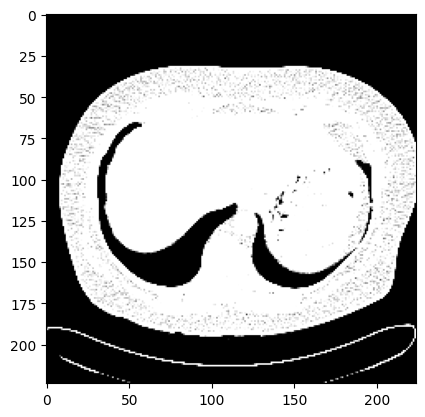

In [144]:
plt.imshow(image[0][0][2] , cmap ="gray")
plt.show()

In [120]:
from monai.transforms import DivisiblePadd, RandomizableTransform, Resize, Transform, NormalizeIntensity


In [121]:
normalize = NormalizeIntensity(channel_wise = True, )

In [122]:
t = normalize(image)

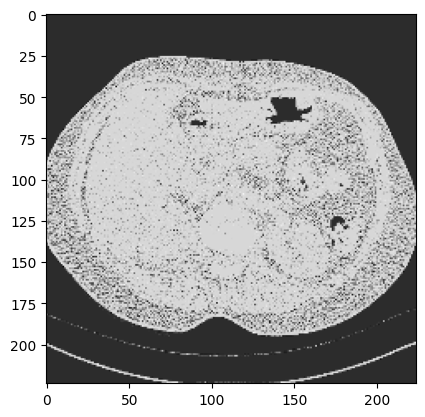

In [90]:
plt.imshow(image[0][0][3] , cmap ="gray")
plt.show()

In [103]:
import torch
from torch.nn.functional import normalize

# define a torch tensor
t = torch.tensor([1., 2., 3., -2., -5.])

# print the above tensor
print("Tensor:", t)

# normalize the tensor
t1 = normalize(t, p=1.0, dim = 0)
t2 = normalize(t, p=2.0, dim = 0)

Tensor: tensor([ 1.,  2.,  3., -2., -5.])


In [109]:
t.std()

tensor(3.2711)

In [105]:
from torchvision import transforms

In [116]:
a = transforms.Normalize(mean = image.mean() , std = image.std(),)

In [117]:
normalize = a(image)

In [115]:
normalize

torch.Size([16, 224, 224])

In [141]:
torch.unique(image)

tensor([0.0000e+00, 4.7472e-07, 9.1553e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])

In [124]:
torch.unique(t)

tensor([-1.7149, -1.7077, -1.7027,  ...,  2.4297,  2.6156,  2.6560])

In [161]:
import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [163]:
from monai.networks import one_hot

In [14]:
one_hot_lung_label = one_hot(lung_label,num_classes = 3)

In [15]:
one_hot_lung_label.shape

torch.Size([8, 3, 16, 224, 224])

In [195]:
image =batch["image"]

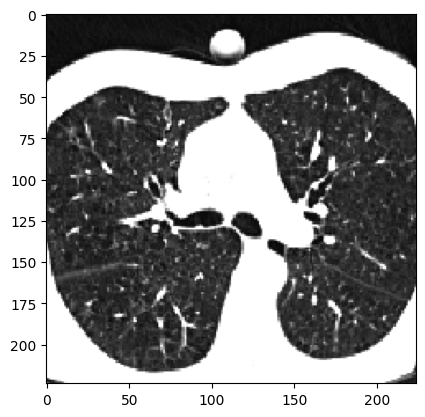

In [205]:
plt.imshow(image[3][0][10] ,cmap ="gray")
plt.show()

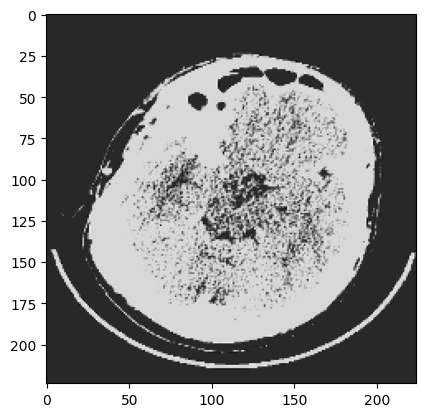

In [251]:
plt.imshow(batch["image"][3][1][10] ,cmap ="gray")
plt.show()

In [35]:
torch.min(image)

tensor(0.)

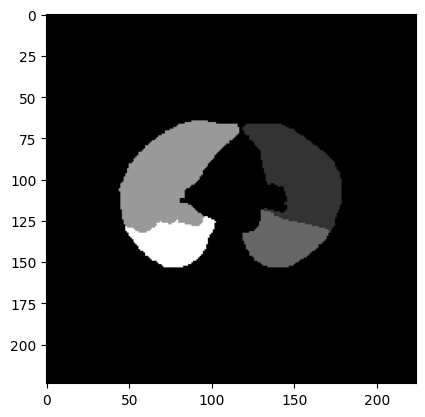

In [32]:
plt.imshow(lobe_label[0][0][8] ,cmap ="gray")
plt.show()

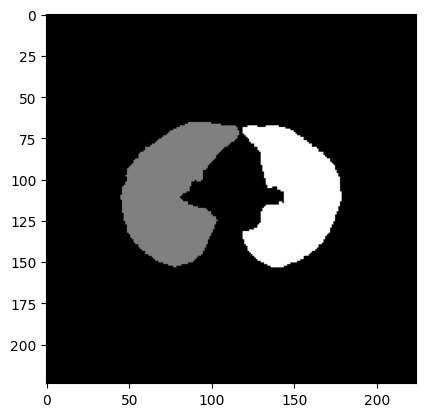

In [33]:
plt.imshow(lung_label[0][0][2] ,cmap ="gray")
plt.show()

In [119]:
import cv2
import numpy as np
def compute_boundary_map(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    eroded = cv2.erode(mask, kernel)
    dilated = cv2.dilate(mask, kernel)
    boundary = dilated - eroded
    return boundary.astype(np.float32)

In [52]:
from torchmetrics import MeanSquaredError
import torch

In [76]:
def boundary_loss(y_true, y_pred):
    print(y_true.shape)
    print(y_pred.shape)
    true_boundary = compute_boundary_map(y_true)
    pred_boundary = compute_boundary_map(y_pred)
    mse = MeanSquaredError()
    return mse(torch.from_numpy(true_boundary), torch.from_numpy(pred_boundary)) , true_boundary


In [219]:
new_target = lung_label.clone()
new_pred = lobe_label.clone()



In [220]:
new_target[new_target == 2] = 1
new_target[new_target == 1] = 1

In [176]:
torch.unique(new_pred)

tensor([0., 1., 2., 3., 4., 5.])

In [221]:
new_pred[new_pred == 2] = 1
new_pred[new_pred == 5] = 1
new_pred[new_pred == 4] = 1
new_pred[new_pred == 3] = 1


In [126]:
y_pred = new_pred[0][0][2]
y_true = new_target[0][0][2]

In [222]:
y_pred = new_pred
y_true = new_target

In [179]:
y_pred.shape

torch.Size([4, 1, 32, 224, 224])

In [121]:
a, b = boundary_loss(y_true , y_pred)

(224, 224)
(224, 224)


In [122]:
a

tensor(0.0009)

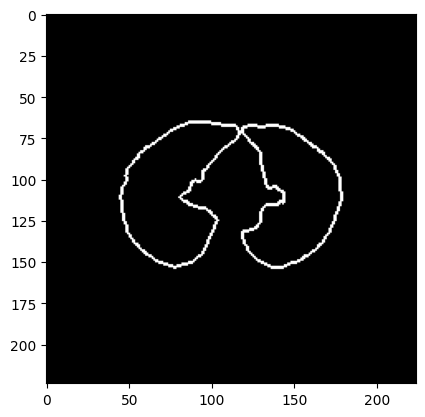

In [123]:
plt.imshow(b ,cmap ="gray")
plt.show()

In [151]:
from kornia.morphology import dilation

In [196]:
import cv2
import numpy as np
import torch

im = np.array([ [0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 1, 1, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0] ], dtype=np.float32)
kernel = np.array([ [1, 1, 1],
                    [1, 1, 1],
                    [1, 1, 1] ], dtype=np.float32)

kernel_t = torch.ones((3,3,3)).unsqueeze(0).unsqueeze(0)
print(cv2.dilate(im, kernel))
# [[1. 1. 1. 0. 0.]
#  [1. 1. 1. 1. 0.]
#  [1. 1. 1. 1. 1.]
#  [1. 1. 1. 1. 1.]
#  [0. 0. 1. 1. 1.]]

im_t = new_target


im_tensor = torch.Tensor(np.expand_dims(np.expand_dims(im, 0), 0)) # size:(1, 1, 5, 5)
# kernel_tensor = torch.Tensor(np.expand_dims(np.expand_dims(kernel, 0), 0)) # size: (1, 1, 3, 3)
dilated_target = torch.clamp(torch.nn.functional.conv3d(im_t, kernel_t, padding=(1, 1,1)), 0, 1)
eroded_target = 1 - torch.clamp(torch.nn.functional.conv3d(1 - im_t, kernel_t, padding=(1,1,1)), 0, 1)

im_t = new_pred


im_tensor = torch.Tensor(np.expand_dims(np.expand_dims(im, 0), 0)) # size:(1, 1, 5, 5)
# kernel_tensor = torch.Tensor(np.expand_dims(np.expand_dims(kernel, 0), 0)) # size: (1, 1, 3, 3)
dilated_pred = torch.clamp(torch.nn.functional.conv3d(im_t, kernel_t, padding=(1, 1,1)), 0, 1)
eroded_pred = 1 - torch.clamp(torch.nn.functional.conv3d(1 - im_t, kernel_t, padding=(1,1,1)), 0, 1)


# tensor([[[[1., 1., 1., 0., 0.],
#           [1., 1., 1., 1., 0.],
#           [1., 1., 1., 1., 1.],
#           [1., 1., 1., 1., 1.],
#           [0., 0., 1., 1., 1.]]]])

[[1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]]


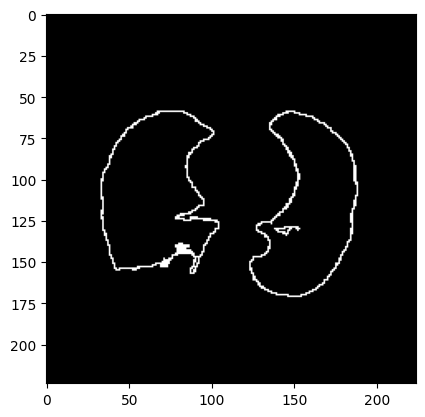

In [200]:
plt.imshow(dilated_pred[1][0][7]- im_t[1][0][7] ,cmap ="gray")
plt.show()

In [199]:
mse = MeanSquaredError()
mse(dilated_target - eroded_target, dilated_pred - eroded_pred)

tensor(0.0036)

In [223]:
from monai.metrics.utils import get_mask_edges, get_surface_distance
import numpy as np

# faster way, using monai
def compute_hausdorff_monai(pred, gt):
#     if np.all(pred == gt):
#         return 0.0
    (edges_pred, edges_gt) = get_mask_edges(pred, gt)
    surface_distance = get_surface_distance(edges_pred, edges_gt, distance_metric="euclidean")
    if surface_distance.shape == (0,):
        return 0.0
    dist = surface_distance.max()
#     if dist > max_dist:
#         return 1.0
    return dist #/ max_dist

In [213]:
def hausdroff_loss(probs, target):
    assert simplex(probs)
    assert simplex(target)
    assert probs.shape == target.shape

    B, K, *xyz = probs.shape  # type: ignore

    pc = cast(Tensor, probs[:, self.idc, ...].type(torch.float32))
    tc = cast(Tensor, target[:, self.idc, ...].type(torch.float32))
    assert pc.shape == tc.shape == (B, len(self.idc), *xyz)

    target_dm_npy: np.ndarray = np.stack([one_hot2hd_dist(tc[b].cpu().detach().numpy())
                                          for b in range(B)], axis=0)
    assert target_dm_npy.shape == tc.shape == pc.shape
    tdm: Tensor = torch.tensor(target_dm_npy, device=probs.device, dtype=torch.float32)

    pred_segmentation: Tensor = probs2one_hot(probs).cpu().detach()
    pred_dm_npy: np.nparray = np.stack([one_hot2hd_dist(pred_segmentation[b, self.idc, ...].numpy())
                                        for b in range(B)], axis=0)
    assert pred_dm_npy.shape == tc.shape == pc.shape
    pdm: Tensor = torch.tensor(pred_dm_npy, device=probs.device, dtype=torch.float32)

    delta = (pc - tc)**2
    dtm = tdm**2 + pdm**2

    multipled = einsum("bkwh,bkwh->bkwh", delta, dtm)

    loss = multipled.mean()

    return loss

In [233]:
pred_t = dilated_pred - eroded_pred
target_t = dilated_target - eroded_target

In [240]:
pred_t.shape

torch.Size([4, 1, 32, 224, 224])

In [236]:
target_t = target_t.to(torch.int8)

In [238]:
torch.unique(target_t)

tensor([0, 1], dtype=torch.int8)

In [245]:
from torchmetrics import Dice

dice = Dice()
dice(pred_t, target_t)

tensor(0.9307)

In [224]:
compute_hausdorff_monai(new_pred, new_target)

0.0

In [214]:
(edges_pred, edges_gt) = get_mask_edges(new_pred, new_target)

In [216]:
new_pred.shape

torch.Size([4, 1, 32, 224, 224])

In [215]:
edges_pred.shape

(4, 1, 32, 115, 164)

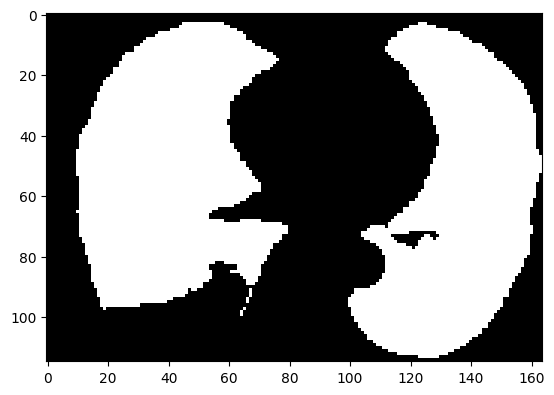

In [217]:
plt.imshow(edges_pred[1][0][7] ,cmap ="gray")
plt.show()

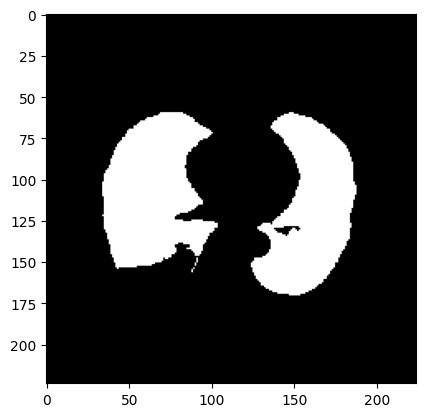

In [194]:
plt.imshow(new_pred[1][0][7] ,cmap ="gray")
plt.show()

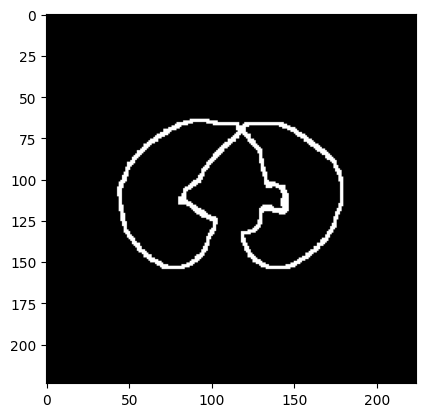

In [170]:
plt.imshow( torch_result[0][0][7] - eroded_img[0][0][7] ,cmap ="gray")
plt.show()

In [172]:
np.unique(torch_result - eroded_img)

array([0., 1.], dtype=float32)

In [173]:
torch_result.shape

torch.Size([1, 1, 32, 224, 224])

In [98]:
kernel.shape

(3, 3)

In [102]:
y_true.shape

(224, 224)

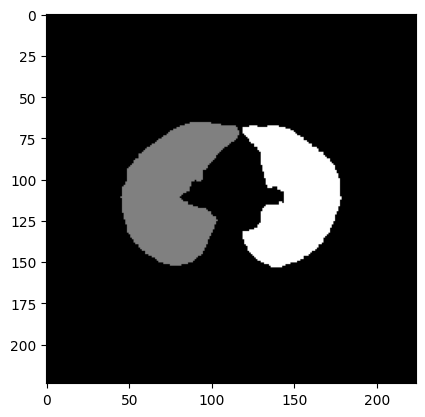

In [71]:
plt.imshow(y_pred ,cmap ="gray")
plt.show()

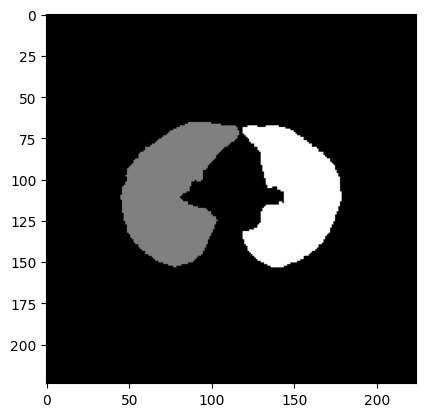

In [72]:
plt.imshow(y_true ,cmap ="gray")
plt.show()

In [31]:
import torch
from torchmetrics import Dice
preds  = torch.tensor([2, 0, 2, 1])
target = torch.tensor([1, 1, 2, 0])
dice = Dice(average='micro')
dice(preds, target)


tensor(0.2500)

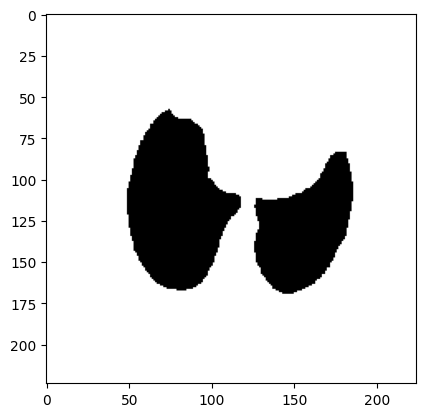

In [21]:
plt.imshow(one_hot_lung_label[0][0][2] ,cmap ="gray")
plt.show()

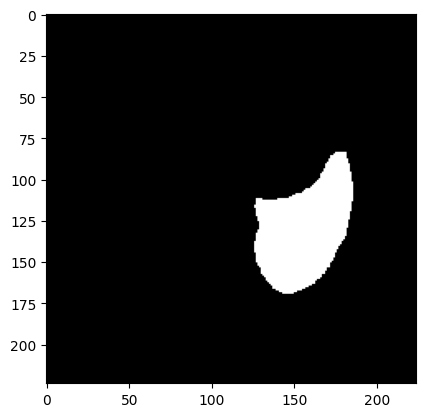

In [36]:
plt.imshow(softmax_lung_label[0][2][2] ,cmap ="gray")
plt.show()

In [25]:
dice = Dice3D()

In [35]:
softmax_lung_label = torch.softmax(one_hot_lung_label ,dim = 1)

In [33]:
one_hot_lung_label.shape

torch.Size([8, 3, 16, 224, 224])

In [37]:
dice(softmax_lung_label ,one_hot_lung_label)

tensor(1.)

In [38]:
softmax_lung_label[0]

tensor([[[[[0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           ...,
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761]],

          [[0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           ...,
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761]],

          [[0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761, 0.5761,  ..., 0.5761, 0.5761, 0.5761],
           [0.5761, 0.5761

In [48]:
import numpy as np
a = np.zeros((200 ,200))

In [49]:
a.shape

(200, 200)

In [51]:
xx, yy = np.where(a)

In [52]:
len(xx)

0

In [58]:
np.unique(a) == 0 

array([ True])

In [18]:
os.listdir("/data_nas5/qct/external_data/samples_244/CT Progression monitoring/Samples/'~$Report Text Anonin - CT Node Calcific - Sample.xlsx'")




['0e54b5f19514301f14cd2e2e033a03b77d7afce6',
 '0d88a4e17e888d6f08731d6e7af35f9b9c3a891c',
 '~$Report Text Anonin - CT Node Calcific - Sample.xlsx',
 '0c60f54d28b484e1d96e87dd16858d268537216f',
 '.DS_Store',
 'Reports.xlsx']

In [20]:
from qure_mini_pacs import create_documents

In [21]:
studies , series , _ = create_documents("/data_nas5/qct/external_data/samples_244/CT Progression monitoring/Samples")

Reading dicom files:   0%|                                                                              | 0/5212 [00:00<?, ?it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.326234.6313135376.37383332393330386338.3666363616135.037'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.623530.0316665303.30346236346437323835.2396164383830.662'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:   0%|                                                                      | 4/5212 [00:00<02:27, 35.32it/s]/home/users/shubham.kumar/mi

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.316634.4343632633.61616566373338643465.0363362663866.163'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:   2%|█▌                                                                 | 125/5212 [00:00<00:32, 155.36it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.613834.0393962653.32343838396339313063.4313962643037.539'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.663636

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.343835.3353866323.62333266336361346434.7313533363761.064'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.643534.6363233383.62366663356464323965.1363566633331.031'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.306439.4626237356.66653038316430396666.0383938646162.236'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633331.8633465666.37616232326438366466.0623032316632.437'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.393630.3363839656.36653733633766376233.0323334343330.633'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.313066.4633437326.38636332386138643733.0656565613261.164'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.636534.1353161383.38333337366338623563.5646565613039.030'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633964.6656461353.64623439393032326335.4353031326462.030'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.383664.4393236323.37633363633164613535.0636538373636.463'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.623965.4643935383.66313839346539666163.5363533643731.030'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  13%|████████▍                                                          | 655/5212 [00:02<00:17, 260.53it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.663735.2623532656.66303863363839386432.0323737353861.231'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.653136

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.336466.6393162613.35386361333761646639.0363365353539.162'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633239.8313665306.36326662343565663266.8303935653662.066'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  15%|██████████▎                                                        | 798/5212 [00:03<00:17, 256.05it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.363131

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.383038.1306563336.62313165326364356132.2306234663565.036'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.313331.8333363663.33363265653634666563.2313333353930.062'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.333834.7613664333.31663662333835303664.0303132316532.935'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.323661.2653562623.66386362663063313232.2383630336539.030'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.323935.3383030643.37323436376364333235.2353364306238.062'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.663830.7323066623.64626531656631653165.0323739366436.830'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.363062.2663836623.39663961336138376133.4306134623730.065'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.316161.0323064306.39343039613535383738.3356265346665.734'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.396162.1333362376.36303162393536393132.0373261653862.638'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

Reading dicom files:  25%|████████████████▎                                                 | 1289/5212 [00:05<00:17, 225.32it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.616239.7323431616.30623232636239313530.0666663393564.665'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.653838.0343162373.30653030613534303639.2626135653263.363'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.616363

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.333233.4653338653.32633535326131613432.4356338336335.036'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.316633.0616530323.30633663663037343262.5633434313366.236'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  27%|██████████████████                                                | 1425/5212 [00:05<00:21, 172.61it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.333339

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.386564.0633863376.66666564303930666638.4346361333234.564'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.363939.3356639656.66346638376132613238.1376638646466.038'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.326135.0373066663.38366562336665613531.5313832396361.066'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.386265.6396162613.36343663363133373363.0333531316633.364'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  31%|████████████████████▍                                             | 1612/5212 [00:06<00:14, 253.16it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.373534.0353637386.31306466343639393166.6313932366131.665'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.373263

Reading dicom files:  33%|█████████████████████▋                                            | 1715/5212 [00:07<00:19, 179.41it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.316663.0623662396.30313364653132323661.6333536636462.637'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.376561.5313332306.65366564323036353461.0383034633031.436'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  33%|█████████████████████▉                                            | 1735/5212 [00:07<00:18, 183.06it/s]/home/users/shubham.kumar/mi

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.303132.0613365323.34626639376537343238.6373031663632.238'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.653533.1333566646.65306162373962623234.0323763333539.166'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.386434.3613836313.37333238643261313362.0393632326637.361'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.383766.7333565303.31323365613332653364.0623939373630.332'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.616165.0303333393.32333865626435303964.8653634316461.231'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  38%|████████████████████████▊                                         | 1961/5212 [00:08<00:15, 208.47it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.313261

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.306635.7633038336.34646364633334666332.0316561383866.231'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.396438.0353034343.31386536643261393965.3646264393636.465'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.393362.6643265363.33366431306666613562.0363434366264.238'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.613234.3373637363.37353665343636326634.6353535333163.033'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633237.8373034646.38366437333633653661.0313439343332.661'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633262.0303039393.66393732313339633830.9623863303461.930'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633162.4623361336.66326239346236336332.3326536646232.038'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  45%|█████████████████████████████▋                                    | 2349/5212 [00:10<00:08, 332.33it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.653563.0353631656.62303334323030616531.6326531633830.232'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.306439

Reading dicom files:  50%|█████████████████████████████████▍                                 | 2597/5212 [00:12<00:47, 55.06it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.653365.1373735613.35376530656466626538.2333638626638.031'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.393862.3633263353.66323265633163336362.4386361353635.030'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.663061

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.323038.6353734613.30346165303731656535.5356632323034.064'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  52%|██████████████████████████████████▎                               | 2711/5212 [00:13<00:17, 144.28it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.616561.5396234316.63303036333432613233.0626530633132.533'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.666466

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.303535.0303162333.35316338363438326533.2396662623061.963'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633166.9653139336.63333563326631336464.1643531373930.035'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.373633.7333766386.32393735653237333833.4626665346534.061'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.653464.0646539363.39373835373031626133.2353364643533.136'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.646164.5316165363.63313264646232646533.0646362356365.334'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.646337.0373762623.62386335306463363633.6623062366336.535'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

Reading dicom files:  58%|██████████████████████████████████████▎                           | 3022/5212 [00:14<00:11, 185.11it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.363964.5633366616.63336265376630346138.0323337386163.334'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.616239.5613535353.38323135653631343637.6633661316132.035'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  58%|██████████████████████████████████████▌                           | 3045/5212 [00:15<00:11, 192.33it/s]/home/users/shubham.kumar/mi

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.313135.9376431376.32383432643537396631.0326362333237.039'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.306463.5666433353.39343535623133633163.2306338663738.033'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  61%|████████████████████████████████████████▍                         | 3189/5212 [00:15<00:09, 209.29it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.333135

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.333234.2313730633.65623130396562373262.0366565653435.630'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.613635.9323334343.33326561333763663463.6663630646262.032'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.663030.2353031653.66396366636435353466.0363334616632.364'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.643734.2646363616.39363731653562616238.0386361326163.532'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633234.0363737633.30356435313961383333.1313461626139.232'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.613065.4366366616.65393532663135633633.8303039363833.062'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.636331.0323930316.63393031333731333938.9623435366231.430'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  68%|████████████████████████████████████████████▌                     | 3520/5212 [00:17<00:09, 183.85it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.613665.0666462626.38306265383537376564.6623732343566.430'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.353039

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.346336.0333430643.61306634616465373463.2633434306561.530'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.373764.5393435383.32386331343835636635.4343739353434.033'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.613466.1643433353.64626534343062346261.6326332353431.036'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.646162.3306336653.62306136643961326562.0613538363438.865'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.366131.9373461346.66653132393264323130.4383464643162.035'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  73%|████████████████████████████████████████████████                  | 3791/5212 [00:19<00:07, 200.57it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.656261

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.663738.1613061623.38663933616135336532.5313734393537.030'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  75%|█████████████████████████████████████████████████▏                | 3884/5212 [00:19<00:06, 193.28it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.626166.2643238323.31316136663932663464.0653839393735.261'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.363362

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.303239.7313562663.33396461363632306431.6356434373733.063'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.343364.0623961613.63643933333035646165.1343462616264.239'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  77%|██████████████████████████████████████████████████▌               | 3995/5212 [00:20<00:06, 191.85it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.653238

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.393362.4363431353.38623030616239396134.0303634303362.161'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  79%|████████████████████████████████████████████████████▍             | 4141/5212 [00:20<00:04, 219.07it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633035.0303964313.61643065376430396365.1616664613237.038'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.373133

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.333835.3336664336.66353964653339326131.3653362616365.034'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.613331.0633539373.35653832313430356662.4393630383334.466'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.636562.8346435306.31323764613335653937.6616662383338.036'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633362.0373562353.37643835613636636632.8663562333937.031'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.363061.0303366326.34373034316336386366.6323565633966.333'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.343833.3626263656.38386363623334303430.0613965643037.136'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.663633.6383237376.62343531353161663832.5363138643236.033'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.376133.0646239643.34313637323365356463.5343934356565.637'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  87%|█████████████████████████████████████████████████████████▏        | 4512/5212 [00:23<00:03, 190.29it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.336139

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633761.2343436356.37316438376264306162.0363565346630.438'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.326333.8323334616.65396437323039666262.5356535653337.063'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.633361.0386234343.38396538326461646663.2636132343739.035'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.626436.4386162636.31653739613165623335.0623338663862.433'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.363239.0666265376.32333137373261303664.2303563313837.166'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.386334.0336231656.33333037646539383131.2363834386536.438'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.656530.0343837386.37616162323332386634.5363364356566.461'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.333736.0303330353.32336234613030363665.0653935336661.537'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.353034.9633231313.33323535303139303536.4336430373435.064'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.643832.8313136396.30343764306435323335.7633664656535.039'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.623137.5303237303.64666230306262356664.2636437616338.062'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.663261.0336432643.63333033313836363866.4666538623537.434'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.313263.5353032346.65343638356336393065.2356130653036.063'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.333032.2363232656.66623136326530633034.0303161636633.933'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Reading dicom files:  98%|████████████████████████████████████████████████████████████████▊ | 5118/5212 [00:25<00:00, 237.93it/s]/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.333863

In [22]:
len(studies)

9

In [23]:
len(series)

56

In [53]:
series_dicts = {}
for i in range(len(series)) : 
    if len(series[i]['InstancesList']) > 140 :
        series_dicts[series[i]['SeriesInstanceUID']] = series[i]
#         suid.append(series[i]['StudyInstanceUID'])
#         print(series[i]['StudyInstanceUID'] , len(series[i]['InstancesList']))

In [55]:
torch.save(series_dicts , "/cache/fast_data_nas72/shubham/sa_sid2dict.pt")

In [51]:
len(set(suid))

9

In [31]:
import pandas as pd

In [34]:
path_xls = "/data_nas5/qct/external_data/samples_244/CT Progression monitoring/Samples/Reports.xlsx"

In [35]:
pd.read_excel(path_xls)

,Patient_ID,Study_Instance_UID,Accession_Number,Report_Text
0,0c60f54d28b484e1d96e87dd16858d268537216f,1.2.840.303163.6393433373.30363966363336663539...,95c4166e3484dbd68af60d0fe0fe5c41bdb84bf2,COMPUTERIZED TOMOGRAPHY OF THE CHEST Examinati...
1,0c60f54d28b484e1d96e87dd16858d268537216f,1.2.840.323132.6633962343.38666164326161653839...,cc474b78ac8ff878fbe50d151345e3da84271511,COMPUTERIZED TOMOGRAPHY OF THE CHEST Clinical ...
2,0c60f54d28b484e1d96e87dd16858d268537216f,1.2.840.363335.6633338616.35323131323639306635...,d68d736cc49594223f42b3aed918f286c139331d,COMPUTERIZED TOMOGRAPHY OF THE CHEST TECHNIQUE...
3,0d88a4e17e888d6f08731d6e7af35f9b9c3a891c,1.2.840.396136.2643838653.31626163643562663137...,1c622ae81d232d8f17d8e504544b2ae7d897bb1b,COMPUTERIZED TOMOGRAPHY OF THE CHEST Examinati...
4,0d88a4e17e888d6f08731d6e7af35f9b9c3a891c,1.2.840.613233.3393833313.33623865326363666534...,4795e608f4e0e72d60f59ceb4cd3b22073ac377e,COMPUTERIZED TOMOGRAPHY OF THE CHEST INDICATIO...
5,0d88a4e17e888d6f08731d6e7af35f9b9c3a891c,1.2.840.643665.9343461373.66646634366134643861...,47ad5ad2689aac4c3329d5e9f90ea96ba2309b66,COMPUTERIZED TOMOGRAPHY OF THE CHEST INDICATIO...
6,0e54b5f19514301f14cd2e2e033a03b77d7afce6,1.2.840.316664.1333237353.62343232653361633763...,5f34f2e2adc51b7a68425c501b7d0cff7ae446d3,COMPUTERIZED TOMOGRAPHY OF THE CHEST Technique...
7,0e54b5f19514301f14cd2e2e033a03b77d7afce6,1.2.840.616261.4376465353.66623364653933396234...,3378020c25d66aa1dd1b602d9c5b9d3476b49f41,COMPUTERIZED TOMOGRAPHY OF THE CHEST Technique...
8,0e54b5f19514301f14cd2e2e033a03b77d7afce6,1.2.840.343533.5623733366.37326432376236366164...,fd79dbdcb14866aabca0eabdf57712213b60906e,COMPUTERIZED TOMOGRAPHY OF THE CHEST Clinical ...


In [24]:
series[0]

{'_id': '1.2.840.303139.6393330323.61333764306365663832.2356466356163.134',
 'Type': 'Series',
 'SeriesInstanceUID': '1.2.840.303139.6393330323.61333764306365663832.2356466356163.134',
 'StudyInstanceUID': '1.2.840.363335.6633338616.35323131323639306635.3343239303162.037',
 'SeriesNumber': 4,
 'SeriesDate': '',
 'SeriesTime': '',
 'SeriesDescription': 'MEDIASTINO',
 'Modality': 'CT',
 'BodyPartExamined': '',
 'FrameOfReferenceUID': '',
 'AcquisitionNumber': None,
 'ContrastAgent': '',
 'ScanningSequence': '',
 'EchoNumber': '',
 'TemporalPosition': '',
 'PatientID': '0c60f54d28b484e1d96e87dd16858d268537216f',
 'StudyID': '',
 'StudyDate': '20210729',
 'StudyTime': '000000',
 'AccessionNumber': 'd68d736cc49594223f42b3aed918f286c139331d',
 'InstitutionName': '',
 'ReferringPhysician': '',
 'PerformingPhysiciansName': '',
 'StudyDescription': 'TOMOGRAFIA COMPUTADORIZADA DE TORAX',
 'PatientName': '1766a1192c1855001aaf52cc7cf3ee2d7324f76b',
 'PatientSex': 'F',
 'PatientAge': '069Y',
 'Inst

In [ ]:



import shutil

# Source path
for i in range(len(filenames)): 
    source = filenames[i]

    # Destination path
    destination = f"/home/users/shubham.kumar/new_headct_prod/series_classifier_testing/series-classifier/tests/example_files/classifier/plain_isc/{os.path.basename(source)}"

    # Copy the content of
    # source to destination

    try:
        shutil.copy(source, destination)
        print("File copied successfully.")

    # If source and destination are same
    except shutil.SameFileError:
        print("Source and destination represents the same file.")

    # If there is any permission issue
    except PermissionError:
        print("Permission denied.")

    # For other errors
    except:
        print("Error occurred while copying file.")
        
        